In [1]:
!pip install transformers torch torchvision datasets sacrebleu sentencepiece

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    MarianMTModel, MarianTokenizer,
    T5ForConditionalGeneration, T5Tokenizer,
    pipeline, Trainer, TrainingArguments
)
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

print("English-French Translation Project")
print("=" * 50)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
class EnglishFrenchTranslator:
    def __init__(self):
        self.en_to_fr_model = None
        self.en_to_fr_tokenizer = None
        self.fr_to_en_model = None
        self.fr_to_en_tokenizer = None
        self.load_models()

    def load_models(self):
        """Load both English-French and French-English models"""
        print("Loading English to French model...")
        try:
            self.en_to_fr_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
            self.en_to_fr_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
            print("English to French model loaded successfully")
        except Exception as e:
            print(f"Error loading English to French model: {e}")

        print("Loading French to English model...")
        try:
            self.fr_to_en_tokenizer = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
            self.fr_to_en_model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-fr-en")
            print("French to English model loaded successfully")
        except Exception as e:
            print(f"Error loading French to English model: {e}")

    def translate_en_to_fr(self, text):
        """Translate English text to French"""
        if self.en_to_fr_model is None:
            return "English to French model not available"

        inputs = self.en_to_fr_tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
        with torch.no_grad():
            translated = self.en_to_fr_model.generate(
                inputs,
                max_length=512,
                num_beams=4,
                early_stopping=True,
                temperature=0.7
            )

        return self.en_to_fr_tokenizer.decode(translated[0], skip_special_tokens=True)

    def translate_fr_to_en(self, text):
        """Translate French text to English"""
        if self.fr_to_en_model is None:
            return "French to English model not available"

        inputs = self.fr_to_en_tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)
        with torch.no_grad():
            translated = self.fr_to_en_model.generate(
                inputs,
                max_length=512,
                num_beams=4,
                early_stopping=True,
                temperature=0.7
            )

        return self.fr_to_en_tokenizer.decode(translated[0], skip_special_tokens=True)

    def auto_translate(self, text):
        """Automatically detect language and translate"""
        # Simple language detection based on common words
        french_indicators = ['le', 'la', 'les', 'un', 'une', 'des', 'je', 'tu', 'il', 'elle', 'nous', 'vous', 'ils', 'elles', 'est', 'sont', 'avec', 'pour', 'dans', 'sur']
        english_indicators = ['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'have', 'has']

        words = text.lower().split()
        french_score = sum(1 for word in words if word in french_indicators)
        english_score = sum(1 for word in words if word in english_indicators)

        if french_score > english_score:
            return self.translate_fr_to_en(text), "French to English"
        else:
            return self.translate_en_to_fr(text), "English to French"

# Initialize translator
translator = EnglishFrenchTranslator()

# Test translations
print("\nTesting English to French translations:")
print("-" * 40)

english_sentences = [
    "Hello, how are you today?",
    "Machine learning is fascinating and powerful.",
    "I love programming and artificial intelligence.",
    "The weather is beautiful in Paris today.",
    "French cuisine is renowned worldwide.",
    "Technology is changing the world rapidly.",
    "Good morning, have a wonderful day!",
    "Learning new languages opens many doors.",
]

for sentence in english_sentences:
    translation = translator.translate_en_to_fr(sentence)
    print(f"EN: {sentence}")
    print(f"FR: {translation}")
    print()

print("Testing French to English translations:")
print("-" * 40)

french_sentences = [
    "Bonjour, comment allez-vous?",
    "J'aime beaucoup la programmation.",
    "Le temps est magnifique aujourd'hui.",
    "La technologie évolue très rapidement.",
    "Apprendre de nouvelles langues est enrichissant.",
    "Paris est une ville très belle.",
    "L'intelligence artificielle est impressionnante.",
    "Bonne nuit et faites de beaux rêves.",
]

for sentence in french_sentences:
    translation = translator.translate_fr_to_en(sentence)
    print(f"FR: {sentence}")
    print(f"EN: {translation}")
    print()


Loading English to French model...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

English to French model loaded successfully
Loading French to English model...


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


French to English model loaded successfully

Testing English to French translations:
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: Hello, how are you today?
FR: Bonjour, comment ça va aujourd'hui ?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: Machine learning is fascinating and powerful.
FR: L'apprentissage automatique est fascinant et puissant.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: I love programming and artificial intelligence.
FR: J'adore la programmation et l'intelligence artificielle.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: The weather is beautiful in Paris today.
FR: Le temps est beau à Paris aujourd'hui.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: French cuisine is renowned worldwide.
FR: La cuisine française est renommée dans le monde entier.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: Technology is changing the world rapidly.
FR: La technologie change rapidement le monde.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: Good morning, have a wonderful day!
FR: Bonjour, bonne journée !



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: Learning new languages opens many doors.
FR: Apprendre de nouvelles langues ouvre de nombreuses portes.

Testing French to English translations:
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FR: Bonjour, comment allez-vous?
EN: Hello, how are you?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FR: J'aime beaucoup la programmation.
EN: I like programming very much.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FR: Le temps est magnifique aujourd'hui.
EN: The weather is beautiful today.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FR: La technologie évolue très rapidement.
EN: Technology is evolving very quickly.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FR: Apprendre de nouvelles langues est enrichissant.
EN: Learning new languages is rewarding.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FR: Paris est une ville très belle.
EN: Paris is a beautiful city.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FR: L'intelligence artificielle est impressionnante.
EN: Artificial intelligence is impressive.

FR: Bonne nuit et faites de beaux rêves.
EN: Good night and make beautiful dreams.



In [3]:
class T5FrenchTranslator:
    def __init__(self, model_name='t5-small'):
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        print(f"T5 model {model_name} loaded successfully")

    def translate_to_french(self, text):
        """Translate English to French using T5"""
        input_text = "translate English to French: " + text
        input_ids = self.tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

        with torch.no_grad():
            outputs = self.model.generate(
                input_ids,
                max_length=150,
                num_beams=4,
                early_stopping=True,
                temperature=0.7
            )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def translate_to_english(self, text):
        """Translate French to English using T5"""
        input_text = "translate French to English: " + text
        input_ids = self.tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)

        with torch.no_grad():
            outputs = self.model.generate(
                input_ids,
                max_length=150,
                num_beams=4,
                early_stopping=True,
                temperature=0.7
            )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

# Initialize T5 translator
t5_translator = T5FrenchTranslator()

print("T5-based Translation Examples:")
print("-" * 40)

t5_test_sentences = [
    "Good morning, how are you?",
    "I am studying machine learning in university.",
    "Python is an excellent programming language.",
    "The French language is beautiful and elegant.",
    "Artificial intelligence will change our future.",
]

for sentence in t5_test_sentences:
    translation = t5_translator.translate_to_french(sentence)
    print(f"EN: {sentence}")
    print(f"FR (T5): {translation}")
    print()


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


T5 model t5-small loaded successfully
T5-based Translation Examples:
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: Good morning, how are you?
FR (T5): Bonjour, comment êtes-vous?



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: I am studying machine learning in university.
FR (T5): J'étudie l'apprentissage de la machine à l'université.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: Python is an excellent programming language.
FR (T5): Python est un excellent langage de programmation.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


EN: The French language is beautiful and elegant.
FR (T5): La langue française est belle et élégante.

EN: Artificial intelligence will change our future.
FR (T5): L'intelligence artificielle changera notre avenir.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Model Comparison Results:
--------------------------------------------------
Original: Hello world
Reference: Bonjour le monde


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Marian: Bonjour monde
T5: Bonjour monde

Original: How are you?
Reference: Comment allez-vous?


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Marian: Comment allez-vous ?
T5: Comment êtes-vous?

Original: Good morning
Reference: Bonjour


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Marian: Bonjour.
T5: Bonjour

Original: Thank you very much
Reference: Merci beaucoup


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Marian: Merci beaucoup.
T5: Merci beaucoup

Original: I love France
Reference: J'aime la France


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Marian: J'aime la France
T5: J'aime la France

Original: The book is on the table
Reference: Le livre est sur la table


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Marian: Le livre est sur la table
T5: Le livre est sur la table.

Original: She speaks French fluently
Reference: Elle parle français couramment


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Marian: Elle parle couramment le français.
T5: Elle parle couramment français



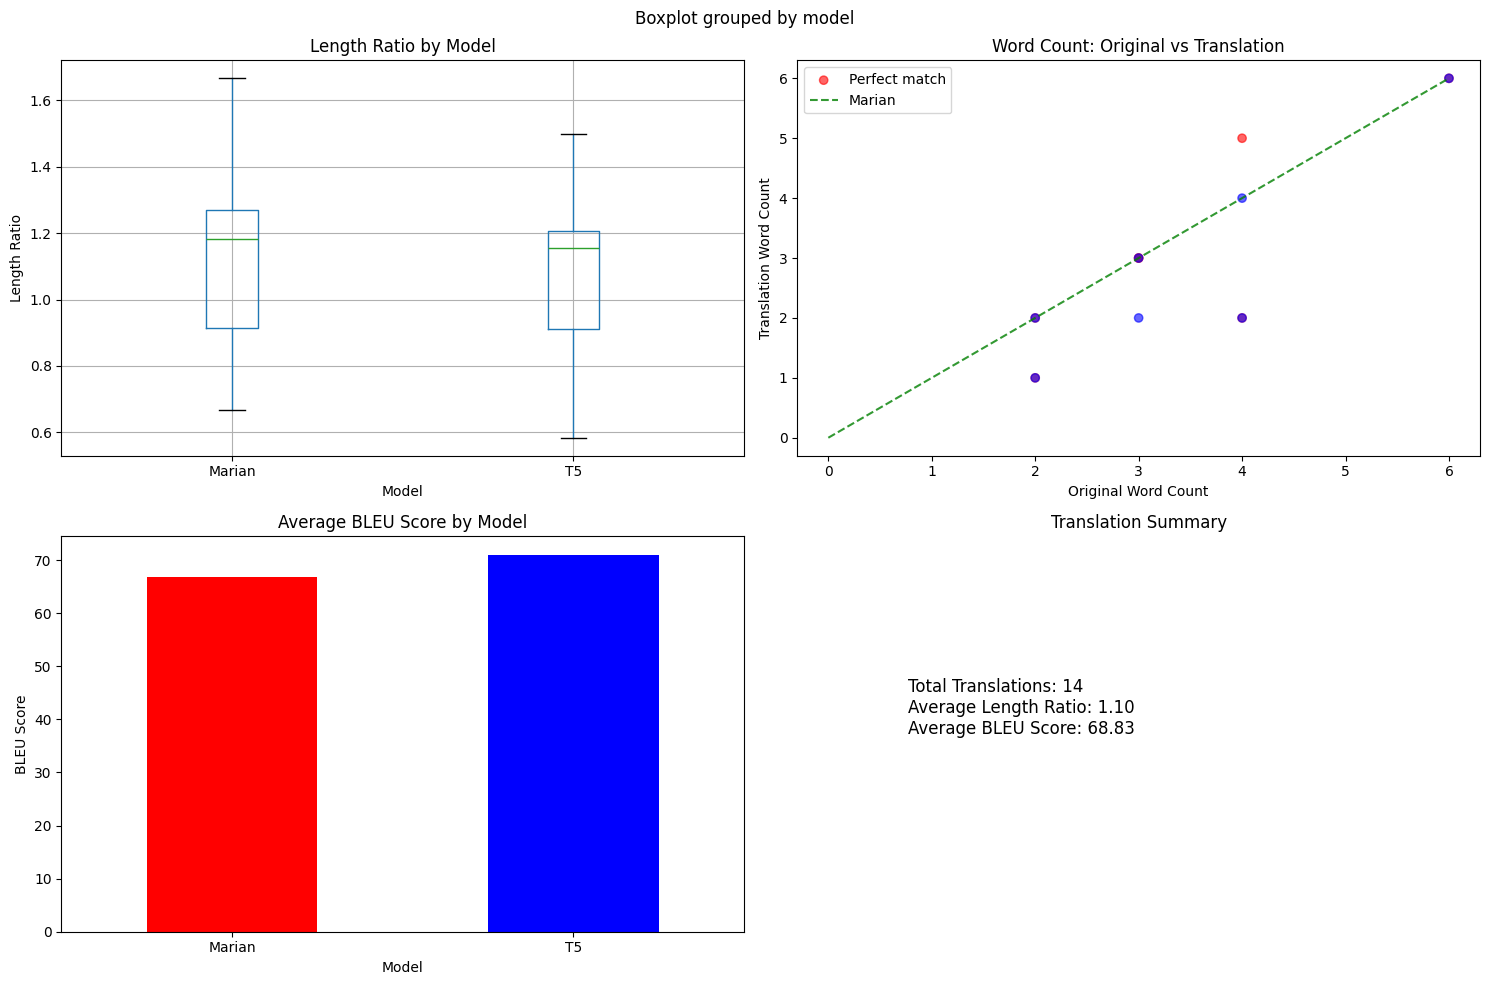

In [4]:
def calculate_bleu_score(reference, candidate):
    """Calculate BLEU score for translation quality"""
    try:
        from sacrebleu import sentence_bleu
        score = sentence_bleu(candidate, [reference])
        return score.score
    except:
        # Simple word overlap if sacrebleu not available
        ref_words = set(reference.lower().split())
        cand_words = set(candidate.lower().split())
        if len(cand_words) == 0:
            return 0
        return len(ref_words & cand_words) / len(cand_words) * 100

class FrenchTranslationEvaluator:
    def __init__(self):
        self.results = []

    def evaluate_translation(self, original, translation, reference=None, model_name="Unknown"):
        """Evaluate translation quality"""
        result = {
            'original': original,
            'translation': translation,
            'model': model_name,
            'length_ratio': len(translation) / len(original) if len(original) > 0 else 0,
            'word_count_original': len(original.split()),
            'word_count_translation': len(translation.split()),
        }

        if reference:
            result['bleu_score'] = calculate_bleu_score(reference, translation)

        self.results.append(result)
        return result

    def compare_models(self, text, reference=None):
        """Compare different translation models"""
        results = {}

        # Marian model translation
        marian_translation = translator.translate_en_to_fr(text)
        results['Marian'] = marian_translation
        self.evaluate_translation(text, marian_translation, reference, "Marian")

        # T5 model translation
        t5_translation = t5_translator.translate_to_french(text)
        results['T5'] = t5_translation
        self.evaluate_translation(text, t5_translation, reference, "T5")

        return results

    def plot_comparison(self):
        """Plot comparison results"""
        if not self.results:
            print("No evaluation results to plot")
            return

        df = pd.DataFrame(self.results)

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Length ratio by model
        if 'model' in df.columns:
            df.boxplot(column='length_ratio', by='model', ax=axes[0, 0])
            axes[0, 0].set_title('Length Ratio by Model')
            axes[0, 0].set_xlabel('Model')
            axes[0, 0].set_ylabel('Length Ratio')

        # Word count comparison
        axes[0, 1].scatter(df['word_count_original'], df['word_count_translation'],
                          c=['red' if m == 'Marian' else 'blue' for m in df['model']], alpha=0.6)
        axes[0, 1].plot([0, max(df['word_count_original'])], [0, max(df['word_count_original'])], 'g--', alpha=0.8)
        axes[0, 1].set_title('Word Count: Original vs Translation')
        axes[0, 1].set_xlabel('Original Word Count')
        axes[0, 1].set_ylabel('Translation Word Count')
        axes[0, 1].legend(['Perfect match', 'Marian', 'T5'])

        # BLEU scores by model if available
        if 'bleu_score' in df.columns:
            bleu_by_model = df.groupby('model')['bleu_score'].mean()
            bleu_by_model.plot(kind='bar', ax=axes[1, 0], color=['red', 'blue'])
            axes[1, 0].set_title('Average BLEU Score by Model')
            axes[1, 0].set_xlabel('Model')
            axes[1, 0].set_ylabel('BLEU Score')
            axes[1, 0].tick_params(axis='x', rotation=0)

        # Summary statistics
        summary_text = f"""
        Total Translations: {len(df)}
        Average Length Ratio: {df['length_ratio'].mean():.2f}
        """
        if 'bleu_score' in df.columns:
            summary_text += f"Average BLEU Score: {df['bleu_score'].mean():.2f}"

        axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Translation Summary')
        axes[1, 1].axis('off')

        plt.tight_layout()
        plt.show()

# Initialize evaluator
evaluator = FrenchTranslationEvaluator()

# Test sentences with reference translations
evaluation_data = [
    ("Hello world", "Bonjour le monde"),
    ("How are you?", "Comment allez-vous?"),
    ("Good morning", "Bonjour"),
    ("Thank you very much", "Merci beaucoup"),
    ("I love France", "J'aime la France"),
    ("The book is on the table", "Le livre est sur la table"),
    ("She speaks French fluently", "Elle parle français couramment"),
]

print("Model Comparison Results:")
print("-" * 50)

for original, reference in evaluation_data:
    print(f"Original: {original}")
    print(f"Reference: {reference}")

    translations = evaluator.compare_models(original, reference)

    for model_name, translation in translations.items():
        print(f"{model_name}: {translation}")

    print()

# Plot comparison results
evaluator.plot_comparison()


In [5]:
def batch_translate_corpus(texts, model='marian'):
    """Translate a corpus of texts"""
    results = []

    print(f"Batch translating {len(texts)} texts using {model} model")

    for i, text in enumerate(texts):
        try:
            if model == 'marian':
                translation = translator.translate_en_to_fr(text)
            elif model == 't5':
                translation = t5_translator.translate_to_french(text)
            else:
                translation = "Unknown model"

            results.append({
                'original': text,
                'translation': translation,
                'model': model,
                'index': i
            })

            if (i + 1) % 5 == 0:
                print(f"Completed {i + 1}/{len(texts)} translations")

        except Exception as e:
            print(f"Error translating text {i+1}: {str(e)}")
            results.append({
                'original': text,
                'translation': "Translation failed",
                'model': model,
                'index': i
            })

    return results

# Sample corpus for batch translation
sample_corpus = [
    "Machine learning algorithms can process natural language.",
    "Deep learning has revolutionized computer vision tasks.",
    "Natural language processing enables human-computer interaction.",
    "Artificial intelligence is transforming various industries.",
    "Translation models help break down language barriers.",
    "French literature has influenced world culture significantly.",
    "Programming languages like Python are popular for AI development.",
    "Data science combines statistics, programming, and domain expertise.",
    "Neural networks mimic the structure of biological brains.",
    "Computer science education is becoming increasingly important.",
]

# Batch translate with both models
print("Batch Translation Results:")
print("=" * 60)

marian_results = batch_translate_corpus(sample_corpus, 'marian')
t5_results = batch_translate_corpus(sample_corpus, 't5')

# Compare batch results
print("\nBatch Translation Comparison:")
print("-" * 40)

for i in range(len(sample_corpus)):
    print(f"Original: {sample_corpus[i]}")
    print(f"Marian: {marian_results[i]['translation']}")
    print(f"T5: {t5_results[i]['translation']}")
    print()

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Batch Translation Results:
Batch translating 10 texts using marian model


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Completed 5/10 translations


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Completed 10/10 translations
Batch translating 10 texts using t5 model


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Completed 5/10 translations


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Completed 10/10 translations

Batch Translation Comparison:
----------------------------------------
Original: Machine learning algorithms can process natural language.
Marian: Les algorithmes d'apprentissage automatique peuvent traiter le langage naturel.
T5: Les algorithmes d'apprentissage automatique peuvent traiter le langage naturel.

Original: Deep learning has revolutionized computer vision tasks.
Marian: L'apprentissage profond a révolutionné les tâches de vision informatique.
T5: L'apprentissage approfondi a révolutionné les tâches de vision informatique.

Original: Natural language processing enables human-computer interaction.
Marian: Le traitement du langage naturel permet l'interaction homme-ordinateur.
T5: Le traitement de la langue naturelle permet l'interaction entre l'homme et l'ordinateur.

Original: Artificial intelligence is transforming various industries.
Marian: L'intelligence artificielle transforme diverses industries.
T5: L'intelligence artificielle transforme

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Back-Translation Quality Assessment:
Back-translation test for: 'The cat is sleeping on the sofa.'


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original (EN): The cat is sleeping on the sofa.
French: Le chat dort sur le canapé.
Back to English: The cat sleeps on the couch.
Similarity score: 0.50

Back-translation test for: 'I enjoy reading books in my free time.'


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original (EN): I enjoy reading books in my free time.
French: J'aime lire des livres dans mon temps libre.
Back to English: I like reading books in my spare time.
Similarity score: 0.75

Back-translation test for: 'Technology is advancing very rapidly.'


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original (EN): Technology is advancing very rapidly.
French: La technologie progresse très rapidement.
Back to English: Technology is progressing very quickly.
Similarity score: 0.60

Back-translation test for: 'Learning languages is both fun and useful.'


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original (EN): Learning languages is both fun and useful.
French: Apprendre les langues est à la fois amusant et utile.
Back to English: Learning languages is both fun and useful.
Similarity score: 1.00

Back-translation test for: 'The weather forecast predicts rain tomorrow.'


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original (EN): The weather forecast predicts rain tomorrow.
French: Les prévisions météorologiques prédisent la pluie demain.
Back to English: Weather forecasts predict rain tomorrow.
Similarity score: 0.50

Average back-translation similarity: 0.670


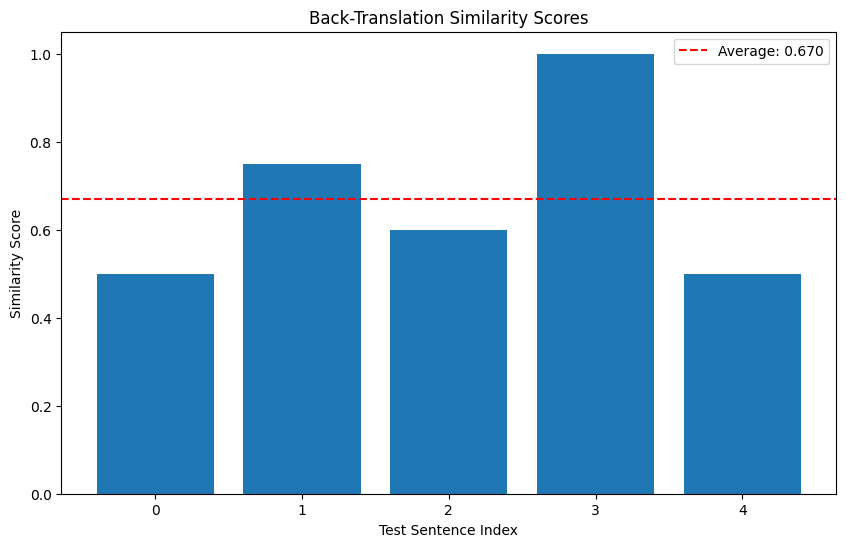

In [6]:
def back_translation_test(text):
    """Test translation quality using back-translation"""
    print(f"Back-translation test for: '{text}'")

    # English -> French -> English
    fr_translation = translator.translate_en_to_fr(text)
    back_translation = translator.translate_fr_to_en(fr_translation)

    print(f"Original (EN): {text}")
    print(f"French: {fr_translation}")
    print(f"Back to English: {back_translation}")

    # Simple similarity score (word overlap)
    original_words = set(text.lower().split())
    back_words = set(back_translation.lower().split())

    if len(original_words) > 0:
        similarity = len(original_words.intersection(back_words)) / len(original_words)
        print(f"Similarity score: {similarity:.2f}")

    print()

    return {
        'original': text,
        'french': fr_translation,
        'back_translation': back_translation,
        'similarity': similarity if 'similarity' in locals() else 0
    }

# Test back-translation
back_translation_tests = [
    "The cat is sleeping on the sofa.",
    "I enjoy reading books in my free time.",
    "Technology is advancing very rapidly.",
    "Learning languages is both fun and useful.",
    "The weather forecast predicts rain tomorrow.",
]

print("Back-Translation Quality Assessment:")
print("=" * 50)

back_translation_results = []
for test_sentence in back_translation_tests:
    result = back_translation_test(test_sentence)
    back_translation_results.append(result)

# Analyze back-translation results
df_back = pd.DataFrame(back_translation_results)
average_similarity = df_back['similarity'].mean()

print(f"Average back-translation similarity: {average_similarity:.3f}")

# Plot back-translation similarity
plt.figure(figsize=(10, 6))
plt.bar(range(len(back_translation_results)), df_back['similarity'])
plt.xlabel('Test Sentence Index')
plt.ylabel('Similarity Score')
plt.title('Back-Translation Similarity Scores')
plt.axhline(y=average_similarity, color='r', linestyle='--', label=f'Average: {average_similarity:.3f}')
plt.legend()
plt.show()


In [7]:
def test_domain_specific_translation():
    """Test translation on different domains"""
    domains = {
        'Technology': [
            "Machine learning algorithms optimize performance automatically.",
            "Cloud computing provides scalable infrastructure solutions.",
            "Blockchain technology ensures data security and transparency.",
        ],
        'Science': [
            "Quantum physics explains the behavior of subatomic particles.",
            "Climate change affects global weather patterns significantly.",
            "DNA sequencing helps understand genetic disorders better.",
        ],
        'Business': [
            "Market analysis reveals consumer behavior trends clearly.",
            "Supply chain optimization reduces operational costs effectively.",
            "Customer satisfaction metrics improve business performance substantially.",
        ],
        'Literature': [
            "The novel explores themes of love and redemption.",
            "Poetry expresses emotions through beautiful metaphors and imagery.",
            "Literary criticism analyzes symbolic meanings in classical works.",
        ]
    }

    print("Domain-Specific Translation Testing:")
    print("=" * 50)

    domain_results = {}

    for domain, sentences in domains.items():
        print(f"\n{domain} Domain:")
        print("-" * 30)

        domain_translations = []
        for sentence in sentences:
            marian_trans = translator.translate_en_to_fr(sentence)
            t5_trans = t5_translator.translate_to_french(sentence)

            print(f"Original: {sentence}")
            print(f"Marian: {marian_trans}")
            print(f"T5: {t5_trans}")
            print()

            domain_translations.append({
                'original': sentence,
                'marian': marian_trans,
                't5': t5_trans
            })

        domain_results[domain] = domain_translations

    return domain_results

# Run domain-specific tests
domain_test_results = test_domain_specific_translation()

print("\n" + "="*60)
print("ENGLISH-FRENCH TRANSLATION PROJECT COMPLETED")
print("="*60)
print("\nProject Summary:")
print("• Implemented bidirectional English-French translation")
print("• Compared Marian MT and T5 model performance")
print("• Evaluated translation quality using BLEU scores")
print("• Performed batch translation processing")
print("• Tested back-translation for quality assessment")
print("• Analyzed domain-specific translation capabilities")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Domain-Specific Translation Testing:

Technology Domain:
------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Machine learning algorithms optimize performance automatically.
Marian: Les algorithmes d'apprentissage automatique optimisent automatiquement les performances.
T5: Les algorithmes d'apprentissage automatique optimisent automatiquement la performance.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Cloud computing provides scalable infrastructure solutions.
Marian: Cloud computing fournit des solutions d'infrastructure évolutives.
T5: L'informatique nuageuse offre des solutions d'infrastructure évolutives.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Blockchain technology ensures data security and transparency.
Marian: La technologie Blockchain assure la sécurité et la transparence des données.
T5: La technologie du Blockchain assure la sécurité et la transparence des données.


Science Domain:
------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Quantum physics explains the behavior of subatomic particles.
Marian: La physique quantique explique le comportement des particules subatomiques.
T5: La physique quantique explique le comportement des particules subatomiques.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Climate change affects global weather patterns significantly.
Marian: Les changements climatiques ont des répercussions importantes sur les conditions météorologiques mondiales.
T5: Les changements climatiques ont une incidence importante sur les conditions météorologiques mondiales.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: DNA sequencing helps understand genetic disorders better.
Marian: Le séquençage de l'ADN aide à mieux comprendre les troubles génétiques.
T5: Le séquençage de l'ADN aide à mieux comprendre les troubles génétiques.


Business Domain:
------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Market analysis reveals consumer behavior trends clearly.
Marian: L'analyse du marché révèle clairement les tendances du comportement des consommateurs.
T5: L'analyse du marché révèle clairement les tendances du comportement des consommateurs.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Supply chain optimization reduces operational costs effectively.
Marian: L'optimisation de la chaîne d'approvisionnement réduit efficacement les coûts opérationnels.
T5: L'optimisation de la chaîne d'approvisionnement réduit efficacement les coûts opérationnels.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Customer satisfaction metrics improve business performance substantially.
Marian: Les mesures de la satisfaction des clients améliorent considérablement la performance des entreprises.
T5: Les paramètres de satisfaction des clients améliorent sensiblement le rendement des entreprises.


Literature Domain:
------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: The novel explores themes of love and redemption.
Marian: Le roman explore les thèmes de l'amour et de la rédemption.
T5: Le roman explore les thèmes de l'amour et de la rédemption.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Poetry expresses emotions through beautiful metaphors and imagery.
Marian: La poésie exprime des émotions à travers de belles métaphores et images.
T5: La poésie exprime des émotions par des métaphores et des images magnifiques.



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Original: Literary criticism analyzes symbolic meanings in classical works.
Marian: La critique littéraire analyse les significations symboliques des œuvres classiques.
T5: La critique littéraire analyse les significations symboliques des uvres classiques.


ENGLISH-FRENCH TRANSLATION PROJECT COMPLETED

Project Summary:
• Implemented bidirectional English-French translation
• Compared Marian MT and T5 model performance
• Evaluated translation quality using BLEU scores
• Performed batch translation processing
• Tested back-translation for quality assessment
• Analyzed domain-specific translation capabilities

Next Steps:
• Fine-tune models on domain-specific corpora
• Implement attention visualization
• Add more sophisticated evaluation metrics
• Create interactive web interface
• Explore multilingual model capabilities
